## **Seungjae Lee and Michael Yu**

Fall 2019

CS 343: Neural Networks

Project 2: Multi-layer Perceptrons

**Draft due 11:59pm Thurs Sept 26**


Summary of files in this project:
- `softmax_layer.ipynb`
- `single_layer_net.py`
- `preprocess_data.py`
- `mlp.ipynb`
- `mlp.py`

**REMINDER**: Submit rubric on Google Classroom

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# for obtaining the STL-dataset
import load_stl10_dataset

# for preprocessing dataset
import preprocess_data

# Set the color style so that Professor Layton can see your plots
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
# Make the font size larger
plt.rcParams.update({'font.size': 20})

# Turn off scientific notation when printing
np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Overview

In this project, you will implement Multilayer Perception (MLP) networks that classify image data belonging to one of 10 classes from the STL-10 dataset. 

You will create two networks that use the softmax activation function and cross-entropy loss: 

- One without a hidden layer (**Task 2**; this notebook) and 
- One with a hidden layer (**Task 3**; ``mlp.ipynb``)

Before implementing the MLP with hidden layer, we will create a simpler single layer network (similar architecture to ADALINE) to test your loss and activation function code.

Focus areas in this project are:
- Working with a large dataset
- Batch vs stochastic training
- Regularization
- Multi-class data classification
- Network weight visualization

## Task 1) Download and preprocess datasets


### a. STL-10

More info: https://cs.stanford.edu/~acoates/stl10/

**Properties:**
- 10 classes of images: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck
- 5000 images.
- 96x96 resolution (we will work with them converted to 32x32 for rapid development and debugging purposes)


#### (i) Download the STL-10 dataset, convert to 32x32 images

This data acquistion script should "just work". You're welcome to take a peek at the script to see where the data is going, but you shouldn't need to tinker with it. It needs to download the dataset from the internet, which might take a few minutes. I set up the script so that it caches the dataset locally in your project folder, so you should only need to download it once. There is a progress percentage indicator.

You should see the following output:

`Images are: (5000, 96, 96, 3)
Labels are: (5000,)
Resizing 5000 images to 32x32...Done!
`

In [2]:
# Download the dataset from the internet, convert it to Numpy ndarray, resize to 32x32
# cache it locally on your computer for faster loading next time.
stl_imgs, stl_labels = load_stl10_dataset.load()

Found cached numpy arrays the images and labels. Loading them...
Images are: (5000, 32, 32, 3)
Labels are: (5000,)


#### (ii) Take a look at a sample of the images in the dataset

Let's take a look at the image categories that we want the neural network to learn

In [3]:
# Load in the string names for each class
classes = np.loadtxt(os.path.join('data', 'stl10_binary', 'class_names.txt'), dtype=str)

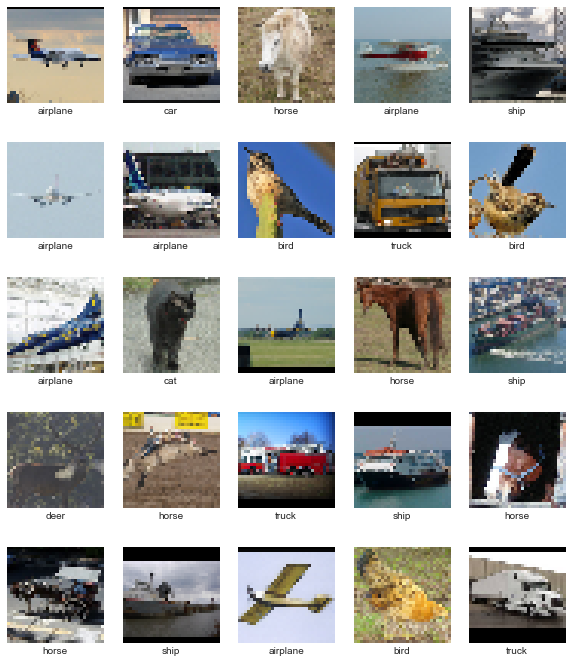

In [4]:
plt.figure(figsize=(10, 12))
plt.subplot
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    randInd = random.randint(0, len(stl_imgs)-1)
    plt.imshow(stl_imgs[randInd])
    plt.xlabel(classes[stl_labels[randInd]-1])
plt.show()

#### (iii) Preprocess the data

Preprocessing data is an important part of working with neural networks. 

**TODO**: Fill in the function `preprocess_stl` in `preprocess_data.py`, implementing the 4 listed goals, to get the desired print out below.

In [5]:
# Preprocess image pixel values for the MLP net
stl_imgs, stl_labels = preprocess_data.preprocess_stl(stl_imgs, stl_labels)

print(f'stl_imgs dtype is {stl_imgs.dtype} and it should be float64')
print(f'stl_imgs max is {np.max(stl_imgs[:, 1:]):.3f} and it should be 0.668')
print(f'stl_imgs shape is {stl_imgs.shape} and it should be (5000, 3072)')
print(f'stl_labels span {stl_labels.min()}->{stl_labels.max()} and it should be 0->9')

stl_imgs dtype is float64 and it should be float64
stl_imgs max is 0.668 and it should be 0.668
stl_imgs shape is (5000, 3072) and it should be (5000, 3072)
stl_labels span 0->9 and it should be 0->9


#### (iii) Create train, validation, test, and dev splits

**TODO**: Complete the `create_splits` function in `preprocess_data.py` to divvy up the dataset into train/test/validation/development subsets, following the two main goals lists. You should obtain a printout as follows:

`Train data shape:  (3500, 3072)
Train labels shape:  (3500,)
Test data shape:  (500, 3072)
Test labels shape:  (500,)
Validation data shape:  (500, 3072)
Validation labels shape:  (500,)
dev data shape:  (500, 3072)
dev labels shape:  (500,)
`

In [20]:
x_train, y_train, x_test, y_test, x_val, y_val, x_dev, y_dev = preprocess_data.create_splits(stl_imgs, stl_labels)  

print ('Train data shape: ', x_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Test data shape: ', x_test.shape)
print ('Test labels shape: ', y_test.shape)
print ('Validation data shape: ', x_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('dev data shape: ', x_dev.shape)
print ('dev labels shape: ', y_dev.shape)

Train data shape:  (3500, 3072)
Train labels shape:  (3500,)
Test data shape:  (500, 3072)
Test labels shape:  (500,)
Validation data shape:  (500, 3072)
Validation labels shape:  (500,)
dev data shape:  (500, 3072)
dev labels shape:  (500,)


## Task 2) Implement single layer network to test softmax activation and cross-entropy loss

You will first implement and test out the softmax activation and cross-entropy loss in a single layer net before embedding it in a more complex multiple layer network.

### a. Implement the following functions

In `single_layer_net.py`, implement the following methods in the base class `SingleLayerNet`:

- `fit`
- `net_in`
- `predict`
- `one_hot`
- `accuracy`


In the child class `SingleLayerNetSoftmax` implement the following methods:

- `activation` (softmax) $f(x_i) = \frac{e^{x_i}}{\sum_{j=1}^C e^{x_j}}$ where $x_i$ are the "net in" values and there are $C$ output neurons (one per input class). $f(x_i)$ is the activation values of each output neuron $i$. Since this is softmax, it is the probability that a given input belongs to the class $i$ coded by the output neuron.
- `loss` (cross-entropy) $L(x_m) = -\frac{1}{B}\sum_{b=1}^B{Log \left (\frac{e^{x_m}}{\sum_{n=1}^C e^{x_n}}\right )}$. $m$ is the correct class for the $b^{th}$ input. $x_m$ is the output neuron activation for the correct class, $x_n$ is the output neuron activation for all of the classes (in the sum). The batch size is $B$, so the loss is averaged over each mini-batch of inputs. The expression in the $Log$ is just the softmax.
- `gradient` (for softmax/cross-entropy)

You're welcome to work in any order, but I recommend starting with `fit` because as you work though it, you should recognize why we need most of the other methods. You can finish `fit` or branch off as you need the other methods.

### b. Test key functions

In [7]:
from single_layer_net import SingleLayerNetSoftmax

In [8]:
# Let's generate some small Gaussian weights equal to the length of an image feature vector
np.random.seed(0)
randWts = np.random.normal(loc=0, scale=0.01, size=(x_dev.shape[1], 10))
b = 1
softmaxNet = SingleLayerNetSoftmax()
randWts.shape

# for test code purposes, use the last 15 images/labels
test_imgs, test_labels = stl_imgs[-15:], stl_labels[-15:]

#### Test the `onehot` function

In [9]:
y_test = np.array([2, 2, 0, 1])
c_test = 4
y_one_hot = softmaxNet.one_hot(y_test, c_test)
print(f'Your one hot vectors:\n{y_one_hot}')

Your one hot vectors:
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


Your one hot vectors should look like:

    [[0. 0. 1. 0.]
     [0. 0. 1. 0.]
     [1. 0. 0. 0.]
     [0. 1. 0. 0.]]

#### Test the `loss`,  `net_in`, softmax `activation` functions

In [10]:
lossNoReg, lossReg = softmaxNet.test_loss(randWts, b, test_imgs, test_labels)
print(f'The loss (without regularization) is {lossNoReg:.2f} and it should approx be 2.28')
print(f'The loss (with 0.5 regularization) is {lossReg:.2f} and it should approx be 3.04')

net in shape=(15, 10), min=0.6586955718394152, max=1.4084436090585783
Should be
net in shape=(15, 10), min=0.6586955718394152, max=1.4084436090585783

net act shape=(15, 10), min=0.07413774498031761, max=0.1416742376747235
Should be
net act shape=(15, 10), min=0.07413774498031761, max=0.14167423767472354

The loss (without regularization) is 2.28 and it should approx be 2.28
The loss (with 0.5 regularization) is 3.04 and it should approx be 3.04


#### Test the `gradient` function

In [11]:
grad_wts, grad_b = softmaxNet.test_gradient(randWts, b, test_imgs, test_labels, 10)
print(f'1st few Wt gradient values are {grad_wts[:4,0]}\nand should be                  [0.01  0.015 0.014 0.007] ')
print(f'1st few Wt bias values are {grad_b[:4]}\nand should be              [ 0.103 -0.099  0.101 -0.026]')

net in: (15, 10), 0.6586955718394152, 1.4084436090585783
y one hot: (15, 10), sum is 15.0
1st few Wt gradient values are [0.01  0.015 0.014 0.007]
and should be                  [0.01  0.015 0.014 0.007] 
1st few Wt bias values are [ 0.103 -0.099  0.101 -0.026]
and should be              [ 0.103 -0.099  0.101 -0.026]


#### Test `fit` function

In [12]:
softmaxNet = SingleLayerNetSoftmax()
loss_history = softmaxNet.fit(x_dev, y_dev, n_epochs=600, mini_batch_sz=250)

Starting to train network...There will be 600 epochs and 1200 iterations total, 2 iter/epoch.
  Completed iter 0/1200. Training loss: 2.31.
  Completed iter 100/1200. Training loss: 2.32.
  Completed iter 200/1200. Training loss: 2.29.
  Completed iter 300/1200. Training loss: 2.26.
  Completed iter 400/1200. Training loss: 2.24.
  Completed iter 500/1200. Training loss: 2.23.
  Completed iter 600/1200. Training loss: 2.23.
  Completed iter 700/1200. Training loss: 2.24.
  Completed iter 800/1200. Training loss: 2.19.
  Completed iter 900/1200. Training loss: 2.21.
  Completed iter 1000/1200. Training loss: 2.17.
  Completed iter 1100/1200. Training loss: 2.18.
Finished training!


Given the random mini-batch sampling process, you should get different specific numbers, but the loss should decrease with iterations. You should get something like this:

    Starting to train network...There will be 600 epochs and 1200 iterations total, 2 iter/epoch.
      Completed iter 0/1200. Training loss: 2.29.
      Completed iter 100/1200. Training loss: 2.30.
      Completed iter 200/1200. Training loss: 2.27.
      Completed iter 300/1200. Training loss: 2.29.
      Completed iter 400/1200. Training loss: 2.27.
      Completed iter 500/1200. Training loss: 2.23.
      Completed iter 600/1200. Training loss: 2.23.
      Completed iter 700/1200. Training loss: 2.23.
      Completed iter 800/1200. Training loss: 2.21.
      Completed iter 900/1200. Training loss: 2.20.
      Completed iter 1000/1200. Training loss: 2.20.
      Completed iter 1100/1200. Training loss: 2.17.
    Finished training!

##### Plot the loss. 

It should look noisy, but on average be decreasing and look roughly linear.

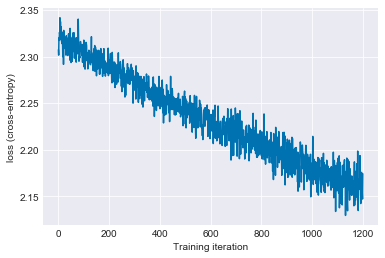

In [13]:
def plot_cross_entropy_loss(loss_history):
    plt.plot(loss_history)
    plt.xlabel('Training iteration')
    plt.ylabel('loss (cross-entropy)')
    plt.show()
    
plot_cross_entropy_loss(loss_history)

**Question 1**: What do you think the linear drop in loss over the epochs tells us about the state of the training process? How is current training going? What's the future potential like?

We still haven't yet reached a loss graph that has ana asymptote. This means that while the current training is heading in the right direction, we can still increase either the number of epochs so we can get a more defined loss.  

#### Test regularization with training. The loss should hover around 17-18 for `reg=10`

**Question 2**: Play around with the regularization parameter. You can drastically change the magnitude, but it should remain positive. How does this affect the training loss and why?

The higher the regularization, the higher our loss starts off at. However, we still see that the loss significantly decreases over the iterations. Increasing regularization prevents the neural net from overfitting by penalizing large weights which is why our loss is higher. If we perfectly fitted the data, we would expect a loss of 0, making the neural net at predicting non training cases. 

Starting to train network...There will be 500 epochs and 500 iterations total, 1 iter/epoch.
  Completed iter 0/500. Training loss: 17.77.
  Completed iter 100/500. Training loss: 14.94.
  Completed iter 200/500. Training loss: 12.64.
  Completed iter 300/500. Training loss: 10.76.
  Completed iter 400/500. Training loss: 9.21.
Finished training!


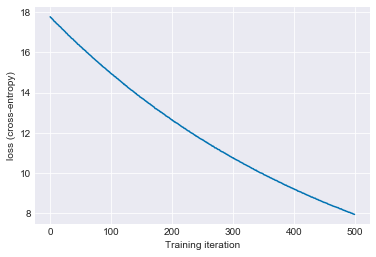

In [14]:
softmaxNet = SingleLayerNetSoftmax()
loss_history = softmaxNet.fit(x_dev, y_dev, reg=10, n_epochs=500)
plot_cross_entropy_loss(loss_history)

#### Test training batch size

**Question 3**: Play around with the batch size parameter. **How does this affect the training loss and why?** (Think about the error gradient and how the weights change)

If we increase our mini batch size while keeping number of epochs constant, our iterations per epoch would go down. This means that we don't get to train our neural net as much. When I ran with a batch size of 1, the loss jumped around from around 3.5  to 0.5. When I increased the batch size to 100, I see a smaller range for the loss. At 500, we consistently get a loss around 2.3. We aren't really changing the weights as much with such a large batch size so are loss isn't really changing either. 

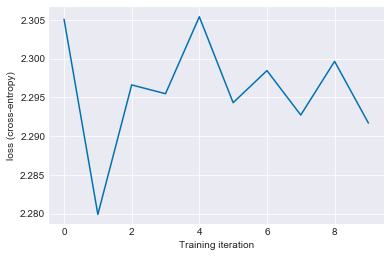

2.2916926382432963


In [15]:
softmaxNet = SingleLayerNetSoftmax()
loss_history = softmaxNet.fit(x_dev, y_dev, mini_batch_sz=500, n_epochs=10, verbose=0);
plot_cross_entropy_loss(loss_history)
print(loss_history[-1])

### c. Train and optimize STL-10 dataset performance, plot results

#### (i) Grid search

As you've surely noticed, hyperparameters can drastically affect learning! 


**TODO:** Implement a grid search for the best hyperparameters

- learning rate,
- regularization
- batch size 

The grid search process should:

1. Fit the model with specific values of hyperparameters that we're testing (using the training set).
2. Compute the accuracy on the training set. 
3. Compute the accuracy on the validation set. 
4. Print out and record the best parameter combination as you go (that improves the **validation set accuracy**).
5. Wipe the weights clean (reinitialize them) every time you try new parameters. It's easiest just to create a new net object on each run.


This can take quite a bit of simulation time!

I suggest implementing the coarse-to-fine search strategy. First try varying parameters over many orders of magnitude. Use the "new best" print outs to refine the ranges that you test. Abort simulations prematurely if you feel there aren't productive (no reason to wait!). This can take however long or short that you want to dedicate. Remember, you are printing out the best parameter values on each run, so you can just proceed with those.

You should be able to achieve ~35% accuracy without too much effort (10% is chance performance).

Your grade won't depend on the accuracy that you achieve, but if you get roughly the above accuracy, the payoff will be cooler visualizations in 2d!

##### Guidelines
- Learning rates above 1e-1 don't really make sense.
- Your mini-batch sizes should be <= N and >= 1

In [16]:
best_val_acc = 0
best_lr = 0.0001
best_reg = 0
best_batch = 10 

upper_lr = 0.01
lower_lr = 0.0001

upper_reg = 25
lower_reg = 0

upper_batch = x_train.shape[0]
lower_batch = 10


arr1 = np.zeros((5,5,5))
arr2 = np.zeros((5,5,5))

for i in range(5):
    for j in range(5):
        for k in range(5):
            batch = int(lower_batch + (upper_batch-lower_batch)/4*i)
            reg = lower_reg + (upper_reg-lower_reg)/4*j
            lr = (lower_lr + (upper_lr-lower_lr)/4*k)
            
            print(i, j, k)
            bestNet = SingleLayerNetSoftmax()
            best_loss = bestNet.fit(x_train, y_train, lr = lr , reg = reg, mini_batch_sz= batch, n_epochs=10, verbose=0)
            y_train_pred = bestNet.predict(x_train)
            y_val_pred = bestNet.predict(x_val)
            test_acc = bestNet.accuracy(y_train, y_train_pred)
            val_acc = bestNet.accuracy(y_val, y_val_pred)
            arr1[i,j,k] = val_acc        
            arr2[i,j,k] = test_acc
            #print(test_acc)
            
print(np.unravel_index(np.argmax(arr1), (5,5,5)))


 

0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 2 0
0 2 1
0 2 2
0 2 3
0 2 4
0 3 0
0 3 1
0 3 2
0 3 3
0 3 4
0 4 0
0 4 1
0 4 2
0 4 3
0 4 4
1 0 0
1 0 1
1 0 2
1 0 3
1 0 4
1 1 0
1 1 1
1 1 2
1 1 3
1 1 4
1 2 0
1 2 1
1 2 2
1 2 3
1 2 4
1 3 0
1 3 1
1 3 2
1 3 3
1 3 4
1 4 0
1 4 1
1 4 2
1 4 3
1 4 4
2 0 0
2 0 1
2 0 2
2 0 3
2 0 4
2 1 0
2 1 1
2 1 2
2 1 3
2 1 4
2 2 0
2 2 1
2 2 2
2 2 3
2 2 4
2 3 0
2 3 1
2 3 2
2 3 3
2 3 4
2 4 0
2 4 1
2 4 2
2 4 3
2 4 4
3 0 0
3 0 1
3 0 2
3 0 3
3 0 4
3 1 0
3 1 1
3 1 2
3 1 3
3 1 4
3 2 0
3 2 1
3 2 2
3 2 3
3 2 4
3 3 0
3 3 1
3 3 2
3 3 3
3 3 4
3 4 0
3 4 1
3 4 2
3 4 3
3 4 4
4 0 0
4 0 1
4 0 2
4 0 3
4 0 4
4 1 0
4 1 1
4 1 2
4 1 3
4 1 4
4 2 0
4 2 1
4 2 2
4 2 3
4 2 4
4 3 0
4 3 1
4 3 2
4 3 3
4 3 4
4 4 0
4 4 1
4 4 2
4 4 3
4 4 4
(0, 0, 4)


#### (ii) Evaluate best model on test set

**Question 4:** Now that you have "good" parameter values recorded, train a new model with the best learning rate, regularization strength, and batch size values. What accuracy do you get on the test set?

We got an accuracy of 0.354 on our test set. After running our best paramaters on the net, we got images that resembled the labels. We then fiddled around with some stuff and now we can't get back to where we were earlier and kind of gave up 

In [24]:
#previous chunk output: (0,0,4)

#calculating best batch, reg, and lr
i = 0
j = 0
k = 4



print(int(lower_batch + (upper_batch-lower_batch)/5*i))
print( lower_reg + (upper_reg-lower_reg)/5*j)
print((lower_lr + (upper_lr-lower_lr)/5*k))
 

10
0.0
0.00802


In [25]:
# TODO: Replace the following with your best values that you find above with grid search
best_lr = 0.00802
best_reg = 0
best_batch = 10


Test accuracy 0.354


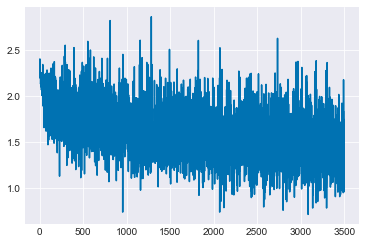

In [26]:
bestNet = SingleLayerNetSoftmax()
best_loss = bestNet.fit(x_train, y_train,
            lr=best_lr, reg=best_reg, mini_batch_sz=best_batch, n_epochs=10, verbose=0)
y_test_pred = bestNet.predict(x_test)
test_acc = bestNet.accuracy(y_test, y_test_pred)

print(f'Test accuracy {test_acc}')

plt.plot(best_loss)
plt.show()

### d. Visualize learned weights

**TODO:** Run the following code that plots the network weights going to each output neuron. If all goes well, you should see something really cool! Include the plot in your submitted project to show me what you got!

**Note:** the quality of your visualizations will depend on:
- The quality of the hyperparameters that you got via grid search.
- How many epochs that you trained the network before plotting the weights

One extension idea: is to find the combination of the above that result in the best visualizations.

(3072, 10)


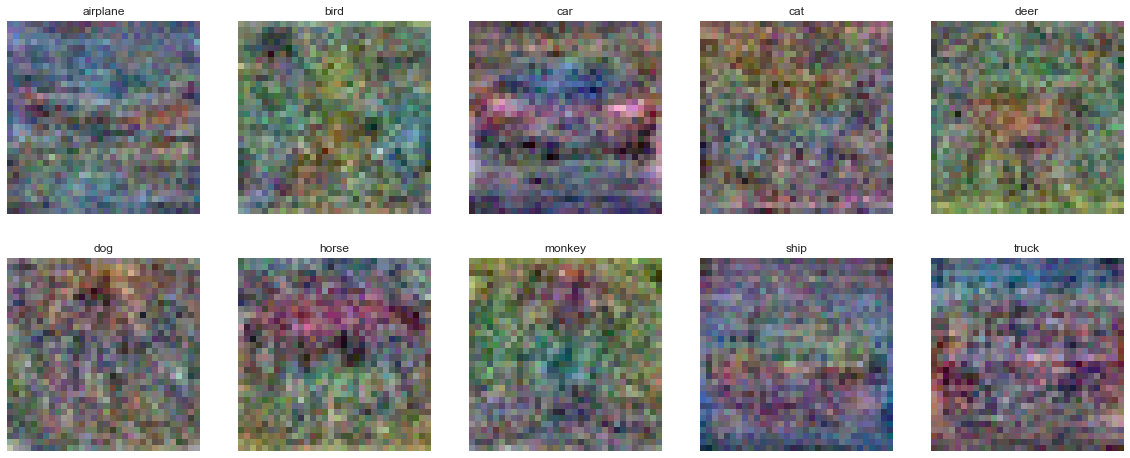

In [27]:
# We don't care about the bias wt
wts = bestNet.wts
print(wts.shape)
# Reshape the wt vectors into spatial 'image' configurations to visualization
wts = wts.reshape(32, 32, 3, 10)

# Make a large new empty figure/plot
plt.figure(figsize=(20, 8))

# Loop through each output neuron
for i in range(10):
  # Make a 2x5 grid of images
  plt.subplot(2, 5, i+1)
  
  # Rescale the weights to be between 0 and 255
  currImg = 255.0 * (wts[:, :, :, i].squeeze() - np.min(wts)) / (np.max(wts) - np.min(wts))
  
  plt.imshow(currImg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])